In [3783]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
from IPython.core.display import display, HTML
from sklearn.preprocessing import MinMaxScaler, RobustScaler

display(HTML("<style>.container { width: 100% !important; }</style>"))

In [3784]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)
train.fillna('NAN', inplace=True) 


test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)
test.fillna('NAN', inplace=True)

submit = pd.read_csv('./open/sample_submission.csv')

In [3785]:
data=pd.concat([train, test], axis=0)
data.shape

(36457, 19)

In [3786]:
train=train.drop(['FLAG_MOBIL'], axis=1)
test=test.drop(['FLAG_MOBIL'], axis=1)

In [3787]:
def minmax(df):
    df = np.array(df).reshape(-1, 1)
    result = MinMaxScaler().fit_transform(df)
    return result

In [3788]:
def days_to_age(x):
    return (x*-1)/365

In [3789]:
# 마이너스 값 변환
def minus(x):
    return x * -1

In [3790]:
train['income_total'] = train['income_total']/10000
train['income_total_dev'] = (train['income_total'] - train['income_total'].mean())**2
#train['income_total_log'] = train['income_total'].apply(np.log)
train['income_total_minmax'] = minmax(train['income_total'])

In [3791]:
train['career'] = train['DAYS_EMPLOYED'].apply( lambda x : 1 if x < 0 else 0)
#train['DAYS_EMPLOYED_log'] = train['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
train.loc[train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_age)
train['DAYS_EMPLOYED_minmax'] = minmax(train['DAYS_EMPLOYED'])
#train['DAYS_EMPLOYED_minmax'] = train['DAYS_EMPLOYED'].apply(minmax)
#train['DAYS_EMPLOYED_one'] = train['DAYS_EMPLOYED']
# train.loc[train['DAYS_EMPLOYED_one'] > 0,'DAYS_EMPLOYED']=0
#train['DAYS_EMPLOYED_dev'] = (train['DAYS_EMPLOYED'] - train['DAYS_EMPLOYED'].mean())**2

In [3792]:
train['begin_month'] = train['begin_month'].apply(minus)
#train['begin_month_log'] = train['begin_month'].apply(np.log)
train['begin_month_minmax'] = minmax(train['begin_month'])
#train['begin_month_minmax'] = train['begin_month'].apply(minmax)
#train['begin_month'] = train['begin_month']//12
# train.loc[train['begin_month'] < 0,'begin_month']=0
# train.loc[train['begin_month'] > 0,'begin_month']=1

In [3793]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
#train['DAYS_BIRTH_log'] = train['DAYS_BIRTH'].apply(np.log)
train['DAYS_BIRTH_minmax'] = minmax(train['DAYS_BIRTH'])
#train['DAYS_BIRTH_minmax'] = train['DAYS_BIRTH'].apply(minmax)
#train['DAYS_BIRTH_dev'] = (train['DAYS_BIRTH'] - train['DAYS_BIRTH'].mean())**2

In [3794]:
train['diff_child'] = train['family_size'] - train['child_num']
train.loc[train['diff_child'] < 0,'diff_child']=0
train.loc[train['diff_child'] > 0,'diff_child']=1
train.loc[train['child_num'] >= 2,'child_num'] = 2
#train.loc[train['family_size'] >= 4,'child_num'] = 4

In [3795]:
#train['total_phone'] = train['work_phone'] + train['phone']

In [3796]:
test['income_total'] = test['income_total']/10000
test['income_total_dev'] = (test['income_total'] - test['income_total'].mean())**2
#test['income_total_log'] = test['income_total'].apply(np.log)
test['income_total_minmax'] = minmax(test['income_total'])
#test['income_total_minmax'] = test['income_total'].apply(minmax)

In [3797]:
test['career'] = test['DAYS_EMPLOYED'].apply( lambda x : 1 if x < 0 else 0)
#test['DAYS_EMPLOYED_log'] = test['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
test.loc[test['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_age)
test['DAYS_EMPLOYED_minmax'] = minmax(test['DAYS_EMPLOYED'])
#test['DAYS_EMPLOYED_minmax'] = test['DAYS_EMPLOYED'].apply(minmax)
# test['DAYS_EMPLOYED_one'] = test['DAYS_EMPLOYED']
# test.loc[test['DAYS_EMPLOYED_one'] > 0,'DAYS_EMPLOYED']=0
# test.loc[test['DAYS_EMPLOYED_one'] < 0,'DAYS_EMPLOYED']=1
#test.loc[test['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
#test['DAYS_EMPLOYED_dev'] = (test['DAYS_EMPLOYED'] - test['DAYS_EMPLOYED'].mean())**2

In [3798]:
test['begin_month'] = test['begin_month'].apply(minus)
#test['begin_month_log'] = test['begin_month'].apply(np.log)
test['begin_month_minmax'] = minmax(test['begin_month'])
#test['begin_month_minmax'] = test['begin_month'].apply(minmax)
#test['begin_month'] = test['begin_month']//12
# test.loc[train['begin_month'] < 0,'begin_month']=0
# test.loc[train['begin_month'] > 0,'begin_month']=1

In [3799]:
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
#test['DAYS_BIRTH_log'] = test['DAYS_BIRTH'].apply(np.log)
test['DAYS_BIRTH_minmax'] = minmax(test['DAYS_BIRTH'])
#test['DAYS_BIRTH_minmax'] = test['DAYS_BIRTH'].apply(minmax)
#test['DAYS_BIRTH_dev'] = (test['DAYS_BIRTH'] - test['DAYS_BIRTH'].mean())**2

In [3800]:
test['diff_child'] = test['family_size'] - test['child_num']
test.loc[test['diff_child'] < 0,'diff_child']=0
test.loc[test['diff_child'] > 0,'diff_child']=1
test.loc[test['child_num'] >= 2,'child_num'] = 2
#test.loc[test['family_size'] >= 4,'child_num'] = 4

In [3801]:
#test['total_phone'] = test['work_phone'] + test['phone']

In [3802]:
def get_try02(data):
    data['gender'] = data['gender'].replace(['F','M'],[0,1])
    data['car'] = data['car'].replace(['N','Y'],[0,1])
    data['reality'] = data['reality'].replace(['N','Y'],[0,1])

        
    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득 Feature 가공. 
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
#     data['EMPLOYED_begin_RATIO'] = data['DAYS_EMPLOYED']/data['begin_month']
#     data['INCOME_begin_RATIO'] = data['income_total']/data['begin_month']
    
    # 가족수와 자녀수 mean, sum 피처 가공
    # data['FAM_CHILD_MEAN'] = data[['child_num', 'family_size']].mean(axis=1)
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # 가족수를 고려한 가처분 소득 피처 가공. 
    # data['CNT_CHILD_INCOME_RATIO'] = data['income_total']/data['child_num']
    data['CNT_FAM_INCOME_RATIO'] = data['income_total']/data['family_size']
    
    # 소유 여부(0/1의 2개 category피처들)와 교육수준 관련 피처들 mean, sum 피처 가공 
    data['HAVE_OR_NOT_MEAN'] =data[['car','reality','work_phone','phone','email', 'edu_type']].mean(axis=1)
    data['HAVE_OR_NOT_car_re'] =data[['car','reality']].sum(axis=1)

    #새로 추가(4/14)
    data['INCOME_HAVE_OR_NOT_RATIO'] = data['income_total']/data['HAVE_OR_NOT_MEAN']
    data['INCOME_HAVE_OR_NOT_RATIO_car_re'] = data['income_total']/data['HAVE_OR_NOT_car_re']
    #data['BIRTH_HAVE_OR_NOT_RATIO_car_re'] = data['DAYS_BIRTH']/data['HAVE_OR_NOT_car_re']
    # data['DAYS_SUM'] = data[['DAYS_BIRTH_BIN', 'DAYS_EMPLOYED_BIN', 'begin_month']].sum(axis=1)
    # data['INCOME_DAYS_SUM_RATIO'] = data['income_total'] / data[['DAYS_BIRTH_BIN', 'DAYS_EMPLOYED_BIN', 'begin_month']].sum(axis=1)

    # 필요없는 피처 삭제 
    # data = data.drop(['work_phone', 'phone', 'email', 'DAYS_EMPLOYED_BIN', 'begin_month_bin'], axis=1)

    return data 

In [3803]:
train = get_try02(train)
test = get_try02(test)

In [3804]:
object_col = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']
# for col in train.columns:
#     if train[col].dtype == 'object':
#         object_col.append(col)
#     elif col in ['phone',  'email', 'work_phone', 'FLAG_MOBIL']:
#         object_col.append(col)
print(object_col)

['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']


In [3805]:
# # sklearn.preprocessing의 LableEncoder 사용하여 income_type, family_type, house_type 처리 
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()

# def label_en(data):
    
#     # ordinary 컬럼 edu_type 인코딩
#     edu_order = {
#         'Lower secondary' : 0, # 중학교 미만
#         'Secondary / secondary special' : 1, #중학교
#         'Incomplete higher' : 2, # 고등학교 중퇴
#         'Higher education' : 3, # 고등학교 졸업
#          'Academic degree' : 4 # 학사 이상
#     }
#     data['edu_type'] = data['edu_type'].map(edu_order)
    
#     return data
    
# train = label_en(train)
# test = label_en(test)

In [3806]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,diff_child,EMPLOYED_BIRTH_RATIO,INCOME_EMPLOYED_RATIO,INCOME_BIRTH_RATIO,FAM_CHILD_SUM,CNT_FAM_INCOME_RATIO,HAVE_OR_NOT_MEAN,HAVE_OR_NOT_car_re,INCOME_HAVE_OR_NOT_RATIO,INCOME_HAVE_OR_NOT_RATIO_car_re
0,0,0,0,0,20.25,Commercial associate,Higher education,Married,Municipal apartment,38.079452,...,1.0,0.338801,1.569601,0.531783,2.0,10.125,0.0,0,inf,inf
1,0,0,1,1,24.75,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,31.178082,...,1.0,0.135325,5.866071,0.793827,4.0,8.250,0.4,1,61.875,24.750
2,1,1,1,0,45.00,Working,Higher education,Married,House / apartment,52.293151,...,1.0,0.232305,3.704330,0.860533,2.0,22.500,0.6,2,75.000,22.500
3,0,0,1,0,20.25,Commercial associate,Secondary / secondary special,Married,House / apartment,41.336986,...,1.0,0.138653,3.533102,0.489876,2.0,10.125,0.4,1,50.625,20.250
4,0,1,1,0,15.75,State servant,Higher education,Married,House / apartment,41.197260,...,1.0,0.139988,2.730998,0.382307,2.0,7.875,0.4,2,39.375,7.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,22.50,State servant,Secondary / secondary special,Married,House / apartment,33.093151,...,1.0,0.164252,4.139365,0.679899,6.0,5.625,0.0,0,inf,inf
26453,0,0,1,1,18.00,Working,Higher education,Separated,House / apartment,41.893151,...,1.0,0.161860,2.654545,0.429665,3.0,9.000,0.2,1,90.000,18.000
26454,0,1,0,0,29.25,Working,Secondary / secondary special,Civil marriage,With parents,27.621918,...,1.0,0.199861,5.298387,1.058942,2.0,14.625,0.2,1,146.250,29.250
26455,1,0,1,0,17.10,Working,Incomplete higher,Single / not married,House / apartment,27.794521,...,1.0,0.010547,58.331776,0.615229,1.0,17.100,0.2,1,85.500,17.100


In [3807]:
enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

OneHotEncoder()

In [3808]:
train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [3809]:
test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [3810]:
#minus 변경하고
#구간화 함수
def make_bin(df, variable, n):
    data = df
    #data[variable] =- data[variable]
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]

In [3811]:
#make_bin(train, 'income_total', n=7)
#make_bin(train, 'income_total_log', n=25)
make_bin(train, 'DAYS_BIRTH', n=10)
# #make_bin(train, 'begin_month', n=6)
#make_bin(train, 'DAYS_EMPLOYED', n=6)
#make_bin(train, 'DAYS_EMPLOYED', n=2)
#make_bin(train, 'child_num', n=2)

In [3812]:
#make_bin(test, 'income_total', n=7)
#make_bin(test, 'income_total_log', n=25)
make_bin(test, 'DAYS_BIRTH', n=10)
# #make_bin(test, 'begin_month', n=6)
#make_bin(test, 'DAYS_EMPLOYED', n=6)
#make_bin(train, 'DAYS_EMPLOYED', n=2)
#make_bin(train, 'child_num', n=2)

In [3813]:
# enc = OneHotEncoder()
# object_col = ['DAYS_BIRTH_bin']
# enc.fit(train.loc[:,object_col])

In [3814]:
# train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# train.drop(object_col, axis=1, inplace=True)
# train = pd.concat([train, train_onehot_df], axis=1)
train = train.drop(['income_total', 'DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED'], axis=1)

In [3815]:
# test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
#              columns=enc.get_feature_names(object_col))
# test.drop(object_col, axis=1, inplace=True)
# test = pd.concat([test, test_onehot_df], axis=1)
test = test.drop(['income_total', 'DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED'], axis=1)

In [3816]:
train.shape, test.shape

((26457, 66), (10000, 65))

In [3817]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
import catboost as cat

In [3818]:
dtrain = xgb.DMatrix(train.drop(['credit'],axis=1), train['credit'])

In [3819]:
def xgb_evaluate(max_depth, subsample, colsample_bytree, learning_rate):
    params = {'eval_metric': 'mlogloss',
                'objective': 'multi:softprob',
#                 'gpu_id': 0,
#                 'tree_method': 'gpu_hist',
#                 'predictor': 'gpu_predictor',
                #                 'booster' : 'dart',
                'num_class' : 3,
                'max_depth': int(max_depth),
                'subsample': subsample,
                'eta': learning_rate,
                'colsample_bytree': colsample_bytree,   
                #                 'rate_drop': rate_drop,
                #               'max_delta_step':max_delta_step
             }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=200, nfold=5, early_stopping_rounds=50)    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-mlogloss-mean'].iloc[-1]

In [3820]:
# xgb_bo = BayesianOptimization(xgb_evaluate, {
#                                 'max_depth': (4, 12),
#                                 'subsample': (0.4, 1.0),
#                                 'colsample_bytree' :(0.4, 1.0),
# #                                 'rate_drop': (0.1, 0.5),
#                                 'learning_rate': (0.01,0.2)})
# # Use the expected improvement acquisition function to handle negative numbers
# # Optimally needs quite a few more initiation points and number of iterations
# xgb_bo.maximize(init_points=5, n_iter = 5, acq='ei', xi=0.01, random_state=409)

In [3821]:
params = xgb_bo.max['params']
params

{'colsample_bytree': 0.6981799311615691,
 'learning_rate': 0.07977739677257951,
 'max_depth': 11.685487550142128,
 'subsample': 0.5591995476703254}

In [3822]:
params['max_depth'] = 12
params['eval_metric'] = 'mlogloss'
params['objective'] = 'multi:softprob'
params['num_class'] = 3
params['subsample'] = 0.75
params['colsample_bytree'] = 0.3
params['min_child_weight'] = 1.1
params['learning_rate'] = 0.03

params

{'colsample_bytree': 0.3,
 'learning_rate': 0.03,
 'max_depth': 12,
 'subsample': 0.75,
 'eval_metric': 'mlogloss',
 'objective': 'multi:softprob',
 'num_class': 3,
 'min_child_weight': 1.1}

In [3823]:
model = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    verbose_eval = 50
)
model

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.084664,0.000666,1.086376,0.000778
1,1.072454,0.000801,1.075509,0.000823
2,1.059128,0.000846,1.063833,0.000704
3,1.046493,0.001231,1.052688,0.001426
4,1.034264,0.001255,1.042260,0.001493
...,...,...,...,...
383,0.391857,0.001943,0.700110,0.009605
384,0.391425,0.001904,0.700090,0.009637
385,0.390949,0.001803,0.700086,0.009642
386,0.390602,0.001849,0.700107,0.009662


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

train_x = train.drop(['credit'],axis=1)
train_y = train['credit']
dtest2 = xgb.DMatrix(test)

def run_kfold():
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        dtrain = xgb.DMatrix(X_train, y_train)
        dtest = xgb.DMatrix(X_val)
#         clf.fit(X_train, y_train)
        
#         predictions=clf.predict_proba(X_val)
        
        final_gb = xgb.train(params, dtrain, num_boost_round=400, verbose_eval=50)

        predictions = final_gb.predict(dtest)
        test_predictions = final_gb.predict(dtest2)
        
        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+= test_predictions
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold()

FOLD 0 : logloss:0.6957272119828566
FOLD 1 : logloss:0.690583745684638
FOLD 2 : logloss:0.681577823888609
FOLD 3 : logloss:0.6924737853407071
FOLD 4 : logloss:0.7080290784632741
FOLD 5 : logloss:0.6710506955475651
FOLD 6 : logloss:0.6759926005194804
FOLD 7 : logloss:0.6765946987541023
FOLD 8 : logloss:0.7012857919139875


In [3824]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

X_train,X_val,y_train,y_val = train_test_split(train_x,train_y,
                                               stratify=train_y,test_size=0.2,
                                               random_state=10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)
print("===========")



xg_clf = xgb.XGBRFClassifier(max_depth=8,n_estimators=100)
xg_clf.fit(X_train,y_train)
xg_preds = xg_clf.predict_proba(X_val)
print(f"log_loss: {log_loss(to_categorical(y_val), xg_preds)}")

Train set: 
(21165, 65)
(21165,)
Validation set: 
(5292, 65)
(5292,)
[17:42:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log_loss: 0.8171367830204765


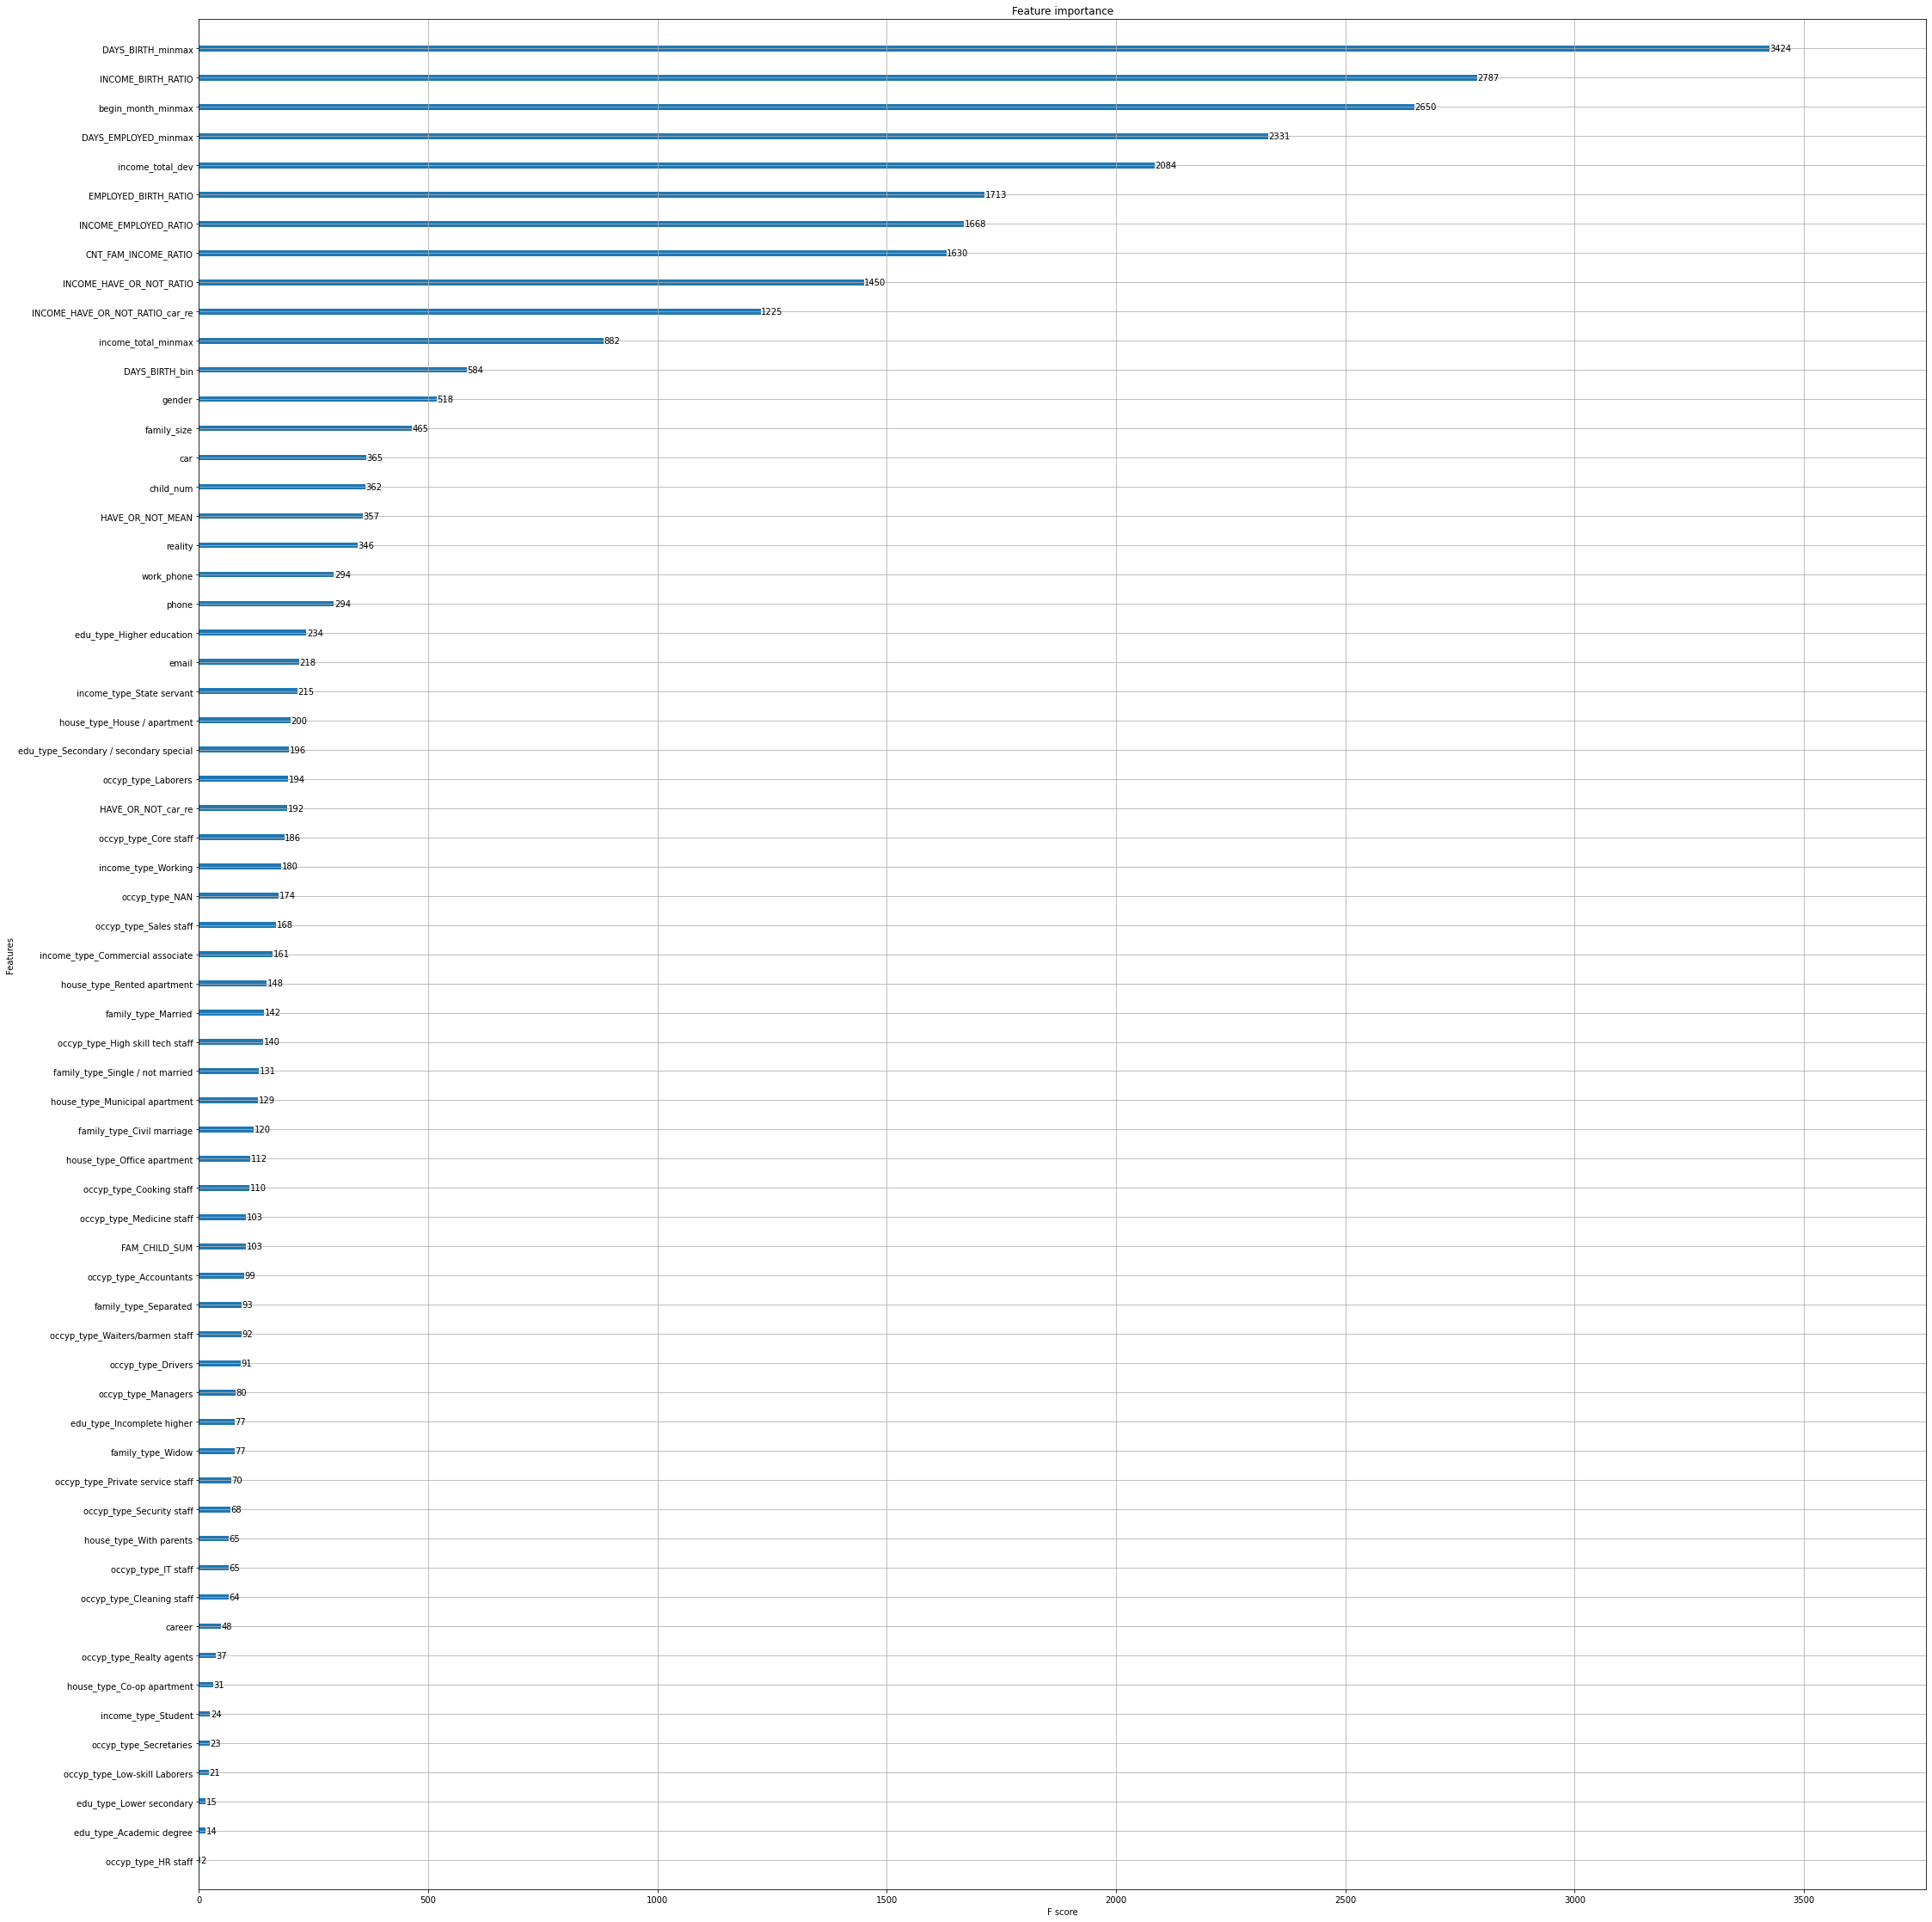

In [3825]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [36, 40]
plt.show()

In [1371]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [1372]:
# clf1 = xgb.XGBClassifier(colsample_bytree = 0.4, subsample=0.98, learning_rate=0.09, 
#                          objective='multi:softprob', max_depth=10)
# clf2 = CatBoostClassifier()

In [1373]:
# clf = StackingClassifier(estimators=[('rf', clf1), ('lgbm', clf2)], #모델 합치기
#     final_estimator=LogisticRegression(),
#                         n_jobs = -1, 
#                         stack_method = 'predict_proba',
#                         cv = 5)
# # rf랑 lgb로부터 나온 예측값에 가중치를 주어서 새로운 파이널 모델에 넣고 재학습. 


In [1374]:
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
# from tensorflow.keras.utils import to_categorical
# def run_kfold(clf):
#     folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
#     outcomes=[]
#     sub=np.zeros((test.shape[0], 3))  
#     for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
#         X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
#         y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
# #         dtrain = xgb.DMatrix(X_train, y_train)
# #         dtest = xgb.DMatrix(X_val)
#         clf.fit(X_train, y_train)
        
#         predictions=clf.predict_proba(X_val)
        
#         #final_gb = xgb.train(params, dtrain, num_boost_round=200, verbose_eval=50)

#         #predictions = final_gb.predict(dtest)
        
#         logloss=log_loss(to_categorical(y_val['credit']), predictions)
#         outcomes.append(logloss)
#         print(f"FOLD {n_fold} : logloss:{logloss}")
        
#         sub+=clf.predict_proba(test)
        
        
#     mean_outcome=np.mean(outcomes)
    
#     print("Mean:{}".format(mean_outcome))
#     return sub/folds.n_splits

# my_submission = run_kfold(clf)

In [1368]:
my_submission

array([[0.08006315, 0.12085713, 0.7990797 ],
       [0.297331  , 0.27516435, 0.42750464],
       [0.02564393, 0.04707146, 0.92728462],
       ...,
       [0.02562607, 0.09092178, 0.88345213],
       [0.1340263 , 0.29370001, 0.57227369],
       [0.0874052 , 0.27575124, 0.63684357]])

In [1369]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.080063,0.120857,0.799080
1,26458,0.297331,0.275164,0.427505
2,26459,0.025644,0.047071,0.927285
3,26460,0.076105,0.102381,0.821514
4,26461,0.055730,0.163550,0.780721
...,...,...,...,...
9995,36452,0.081707,0.293370,0.624924
9996,36453,0.254969,0.278404,0.466627
9997,36454,0.025626,0.090922,0.883452
9998,36455,0.134026,0.293700,0.572274


In [1370]:
submission.to_csv('./submit/10fold_xgb_0.6874.csv', index=False) # 0.7272812144

In [725]:
submission.head(20)

,index,0,1,2
0,26457,0.063042,0.103962,0.832996
1,26458,0.244461,0.231854,0.523685
2,26459,0.037510,0.061729,0.900761
3,26460,0.111942,0.115421,0.772637
4,26461,0.051283,0.136116,0.812601
5,26462,0.053575,0.079100,0.867325
6,26463,0.657437,0.310976,0.031587
7,26464,0.074134,0.121443,0.804423
8,26465,0.051564,0.144243,0.804192
9,26466,0.066304,0.351688,0.582008


In [74]:
submission=pd.read_csv('./submit/10fold_xgb_0.6974.csv') # 0.7272812144
submission[submission['index']==31375]

,index,0,1,2
4918,31375,0.0582,0.072123,0.869677
